# K近邻算法

kNN算法是一种基于实例的分类算法，对于给定标签的训练集，计算新数据与训练集实例的距离，统计最近的k个实例，如果多数属于某一类，则新实例属于该类。

k值的选择、距离度量以及分类决策规则是k近邻算法的三个基本要素。

算法：$1.计算新数据和训练集所有样本的距离\\
2.将距离从小到大排序\\
3.选择最小的k个距离，统计类别，选择最多的一类作为新数据的类别$

优点：精度高、对异常值不敏感、无数据输入假定

缺点：计算复杂度高、空间复杂度高

## 数据导入和可视化分析

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
wh_data = pd.read_csv('武汉.csv', index_col='date', encoding='utf-8', engine='python')
wh_data.drop(index=wh_data[wh_data['质量等级']=='无'].index, inplace=True)
wh_data.head()

,AQI,质量等级,PM2.5,PM10,SO2,CO,NO2,O3_8h
date,,,,,,,,
2014-01-01,203,重度污染,153,210,70,2.0,106,55
2014-01-02,231,重度污染,181,254,89,2.4,112,26
2014-01-03,224,重度污染,174,226,63,1.7,84,55
2014-01-04,147,轻度污染,112,184,73,1.6,87,40
2014-01-05,195,中度污染,147,213,89,2.2,91,53


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = wh_data.loc[:, ['PM2.5','PM10']]
y = wh_data.loc[:, '质量等级']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

standardscaler = StandardScaler()
standardscaler.fit(X_train)
X_train_sca = standardscaler.transform(X_train)
X_test_sca = standardscaler.transform(X_test)

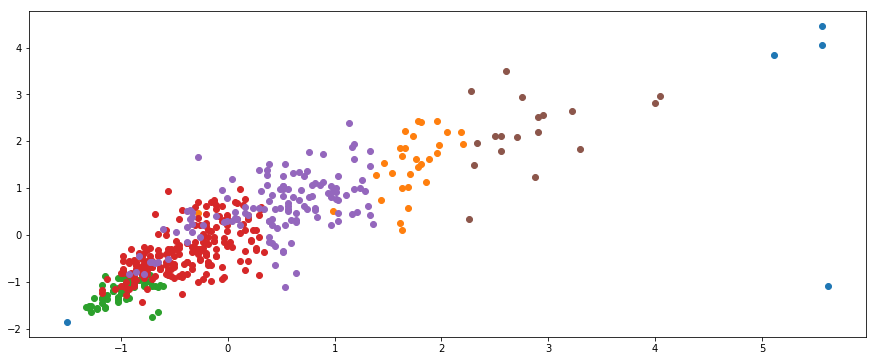

In [4]:
plt.figure(figsize=(15,6))
for label in np.unique(y):
    plt.scatter(X_test_sca[y_test==label, 0], X_test_sca[y_test==label, 1])
plt.show()

## 自定义类

In [0]:
class myKNN():
    def __init__(self, k=5):
        self._X = None
        self._y = None
        self._k = k
        
    def fit(self, X_train, y_train):
        self._X = X_train
        self._y = y_train
        return self
    
    #计算未分类样本与已知类别样本的欧式距离
    def _distance(self, X):   
        distances = np.empty((X.shape[0], self._X.shape[0]))
        for i, x_new in enumerate(X):
            for j, x_train in enumerate(self._X):
                d = np.sqrt(np.sum((x_new - x_train)**2))
                distances[i, j] = d
        return distances
    
    #对距离进行排序，选出最近的k个实例
    def _sort(self, X): 
        distances = self._distance(X)
        d_sorted = np.argsort(distances, axis=1)[:, :self._k]
        Y = []
        for d in d_sorted:
            y_new = self._y[d]
            Y.append(y_new)
        return np.array(Y)
    
    def predict(self, X_test):
        from collections import Counter
        
        y_new = []
        Y_knn = self._sort(X_test)
        for y_knn in Y_knn:
            votes = Counter(y_knn)
            y_new.append(votes.most_common(1)[0][0])
        return np.array(y_new)
    
    def score(self, X_test, y_test):
        y_new = self.predict(X_test)
        return np.sum(y_new==y_test) / len(y_test)

In [6]:
my_kNN = myKNN()
my_kNN.fit(X_train_sca, y_train)
my_kNN.score(X_test_sca, y_test)

0.8127753303964758

**调整k**

In [7]:
best_k = 0
best_score = 0.
for k in range(1,20,2):
    my_kNN = myKNN(k)
    my_kNN.fit(X_train_sca, y_train)
    score = my_kNN.score(X_test_sca, y_test)
    if score > best_score:
        best_score = score
        best_k = k
print(best_k, best_score)

17 0.8325991189427313


## 使用sklearn

In [0]:
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

X = wh_data.iloc[:, 2:]
y = wh_data.iloc[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

knn_clf = Pipeline([
    ('standardscaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

knn_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [10]:
knn_clf.score(X_test, y_test)

0.8480176211453745

**网格搜索**

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())

param_grid = [
    {
        'kneighborsclassifier__weights': ['uniform', 'distance'], 
        'kneighborsclassifier__n_neighbors': [i for i in range(1, 20, 2)],
        'kneighborsclassifier__p': [i for i in range(1, 11)]
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1)

In [12]:
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                 

In [13]:
grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 1,
 'kneighborsclassifier__weights': 'distance'}

In [14]:
knn_clf = grid_search.best_estimator_
knn_clf.fit(X_train, y_train)
knn_clf.score(X_test, y_test)

0.8568281938325991